In [81]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from datetime import datetime, timezone
import numpy as np
import calendar


In [82]:
# Save data in a DataFrame
data = pd.read_csv('/content/clean_secular_talk_data.csv')

# Explore data structure
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19999 entries, 0 to 19998
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   videoId           19999 non-null  object 
 1   title             19999 non-null  object 
 2   description       19622 non-null  object 
 3   tags              19570 non-null  object 
 4   publishedAt       19999 non-null  object 
 5   duration          19999 non-null  object 
 6   category          19999 non-null  object 
 7   viewCount         19999 non-null  int64  
 8   likeCount         19999 non-null  int64  
 9   commentCount      19998 non-null  float64
 10  duration_seconds  19999 non-null  int64  
 11  duration_minutes  19999 non-null  float64
 12  duration_hours    19999 non-null  float64
dtypes: float64(3), int64(3), object(7)
memory usage: 2.0+ MB


In [83]:
# filter videos that last more than 3 hours
data = data.loc[data["duration_seconds"] < 3 * 3600].copy()

# delete videos with more like than views
data = data[~(data["likeCount"] > data["viewCount"])]

# clean date column
data['publishedAt'] = pd.to_datetime(data['publishedAt'])

# filter counts
attributes = [
    "publishedAt"
]

data = data[attributes]

# filter data from 1/1/2020 to 12/31/2025
data = data[data["publishedAt"].between("2020-01-01", "2025-12-31 23:59:59")]

# explore data structure
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9305 entries, 13 to 9324
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype              
---  ------       --------------  -----              
 0   publishedAt  9305 non-null   datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](1)
memory usage: 145.4 KB


In [84]:
# hour of day as numeric (e.g., 13.5 means 1:30 PM)

data["hour"] = (
    data["publishedAt"].dt.hour
    + data["publishedAt"].dt.minute / 60
    + data["publishedAt"].dt.second / 3600
)

In [85]:
# publication time distribution summary

monthly_data = (
    data
    .dropna(subset=["publishedAt", "hour"])
    .groupby(data["publishedAt"].dt.to_period("M"))
    .agg(
        percentile_25=("hour", lambda x: x.quantile(0.25)),
        latest_hour=("hour", "max"),
        median_hour=("hour", "median"),
        earliest_hour=("hour", "min"),
        percentile_75=("hour", lambda x: x.quantile(0.75)),
        video_count=("hour", "count")
    )
    .reset_index()
)

# Convert Period to Timestamp if needed
monthly_data["publishedAt"] = monthly_data["publishedAt"].dt.to_timestamp()

# explore data structure
monthly_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 0 to 71
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   publishedAt    72 non-null     datetime64[ns]
 1   percentile_25  72 non-null     float64       
 2   latest_hour    72 non-null     float64       
 3   median_hour    72 non-null     float64       
 4   earliest_hour  72 non-null     float64       
 5   percentile_75  72 non-null     float64       
 6   video_count    72 non-null     int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 4.1 KB


/tmp/ipython-input-4101385892.py:6: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  .groupby(data["publishedAt"].dt.to_period("M"))


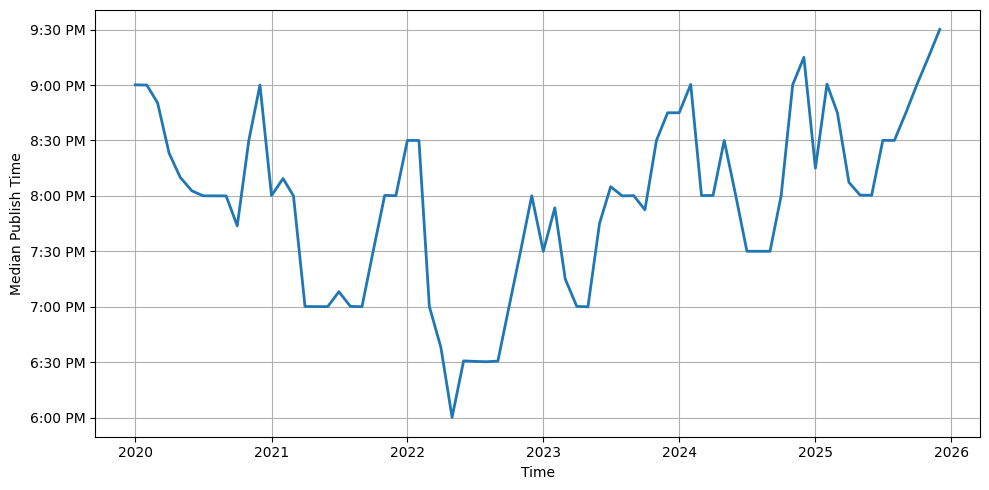

In [96]:
# plot (median publish time)

plt.figure(figsize=(10, 5))

plt.plot(monthly_data["publishedAt"], monthly_data["median_hour"], linewidth=2)
plt.xlabel("Time")
plt.ylabel("Median Publish Time")
plt.grid(True)

# Format y-axis as 12-hour clock (e.g., 6:30 PM)
def hour_to_12h(x, _):
    hour = int(x) % 24
    minute = int(round((x - int(x)) * 60)) % 60
    suffix = "AM" if hour < 12 else "PM"
    hour_12 = hour % 12
    hour_12 = 12 if hour_12 == 0 else hour_12
    return f"{hour_12}:{minute:02d} {suffix}"

plt.gca().yaxis.set_major_formatter(FuncFormatter(hour_to_12h))
plt.tight_layout()
plt.show()

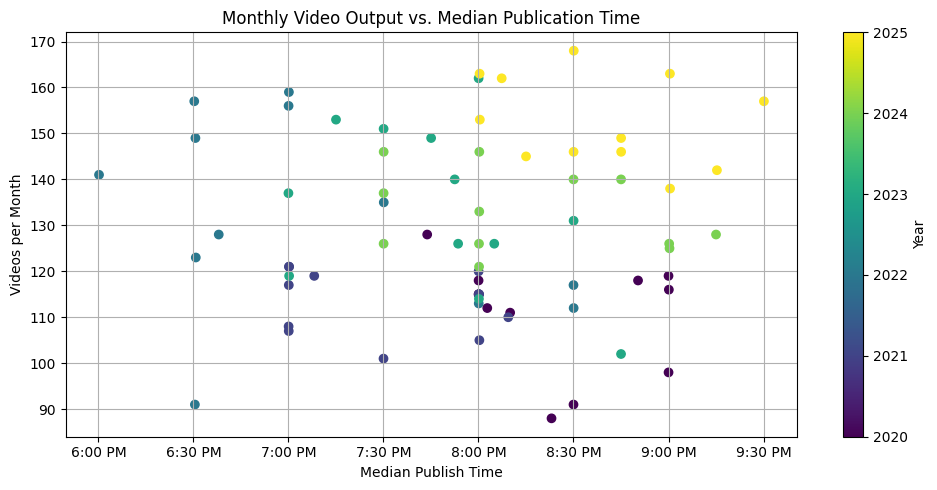

In [93]:
# scatter plot: Monthly Video Output vs. Median Publication Time

plt.figure(figsize=(10, 5))

sc = plt.scatter(
    monthly_data["median_hour"],
    monthly_data["video_count"],
    c=monthly_data["publishedAt"].dt.year,
    cmap="viridis",
    # Greens
    # viridis
    # RdYlGn_r
    alpha=1
)

plt.title("Monthly Video Output vs. Median Publication Time")
plt.xlabel("Median Publish Time")
plt.ylabel("Videos per Month")
plt.grid(True)

# Format x-axis as 12-hour clock
def hour_to_12h(x, _):
    hour = int(x) % 24
    minute = int(round((x - int(x)) * 60)) % 60
    suffix = "AM" if hour < 12 else "PM"
    hour_12 = hour % 12
    hour_12 = 12 if hour_12 == 0 else hour_12
    return f"{hour_12}:{minute:02d} {suffix}"

plt.gca().xaxis.set_major_formatter(FuncFormatter(hour_to_12h))

# Colorbar = legend for year
cbar = plt.colorbar(sc)
cbar.set_label("Year")

plt.tight_layout()
plt.show()

/tmp/ipython-input-1406354995.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(["hour_bin", "year"])["video_count"]


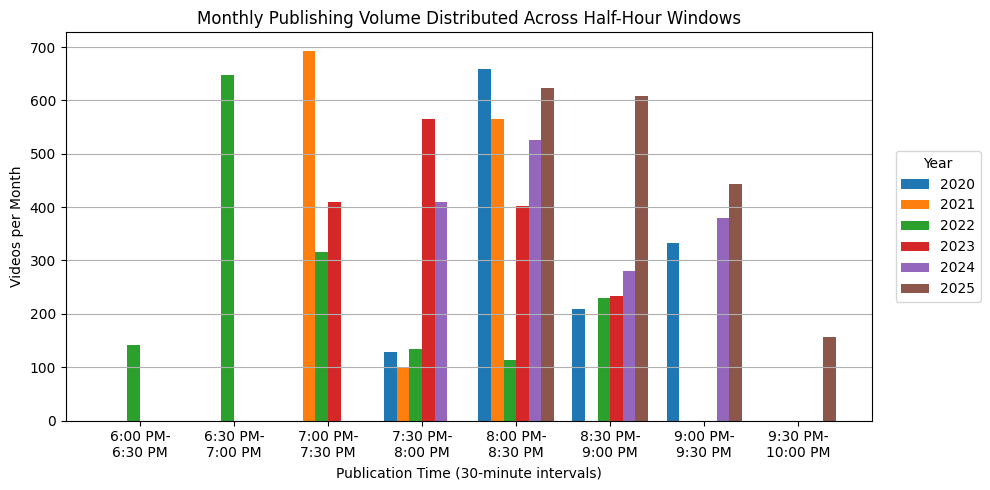

In [95]:
# bar chart: monthly publishing volume distributed across half-hour time windows

df = monthly_data.copy()
df["year"] = df["publishedAt"].dt.year

# 30-minute bins
bins = np.arange(0, 24.5, 0.5)  # 0.0, 0.5, ..., 24.0
df["hour_bin"] = pd.cut(
    df["median_hour"],
    bins=bins,
    include_lowest=True,
    right=False
)

bar_data = (
    df.groupby(["hour_bin", "year"])["video_count"]
      .sum()
      .reset_index()
)

pivot = (
    bar_data
    .pivot(index="hour_bin", columns="year", values="video_count")
    .fillna(0)
)

# Keep only bins where there is at least some data across years
pivot = pivot.loc[pivot.sum(axis=1) > 0]

# --- helper: label as "start-\nend" ---
def half_hour_label_multiline(interval):
    start = interval.left
    end = interval.right

    def fmt(h):
        hour = int(h) % 24
        minute = int(round((h - int(h)) * 60)) % 60
        suffix = "AM" if hour < 12 else "PM"
        hour_12 = hour % 12
        hour_12 = 12 if hour_12 == 0 else hour_12
        return f"{hour_12}:{minute:02d} {suffix}"

    return f"{fmt(start)}-\n{fmt(end)}"

# plot
fig, ax = plt.subplots(figsize=(10, 5))

x = np.arange(len(pivot.index))
bar_width = 0.8 / len(pivot.columns)

for i, year in enumerate(pivot.columns):
    ax.bar(
        x + i * bar_width,
        pivot[year],
        width=bar_width,
        label=str(year)
    )

# X-axis labels: 30-min ranges (two lines)
ax.set_xticks(x + bar_width * (len(pivot.columns) - 1) / 2)
ax.set_xticklabels(
    [half_hour_label_multiline(b) for b in pivot.index]
)

ax.set_title("Monthly Publishing Volume Distributed Across Half-Hour Windows")
ax.set_xlabel("Publication Time (30-minute intervals)")
ax.set_ylabel("Videos per Month")
ax.grid(axis="y", alpha=1)

# Y-axis formatter: 1,000 / 1,000,000
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{int(y):,}"))

# Legend to the side
ax.legend(
    title="Year",
    loc="center left",
    bbox_to_anchor=(1.02, 0.5)
)

plt.tight_layout()
plt.show()

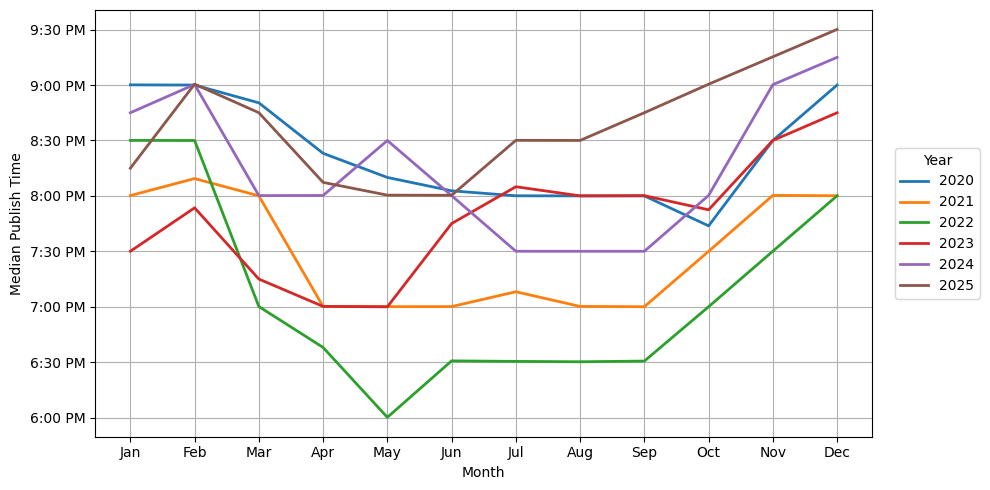

In [94]:
# line graph: monthly publish times by year

df = monthly_data.copy()
df["year"] = df["publishedAt"].dt.year
df["month"] = df["publishedAt"].dt.month

# pivot: months as rows, years as columns
seasonal = (
    df.pivot_table(
        index="month",
        columns="year",
        values="median_hour",
        aggfunc="mean"
    )
    .reindex(range(1, 13))  # ensure Jan–Dec
)

# plot
fig, ax = plt.subplots(figsize=(10, 5))

for year in seasonal.columns:
    ax.plot(
        seasonal.index,
        seasonal[year],
        linewidth=2,
        label=str(year)
    )

ax.set_xlabel("Month")
ax.set_ylabel("Median Publish Time")
ax.grid(True)

# X-axis month labels
ax.set_xticks(range(1, 13))
ax.set_xticklabels([calendar.month_abbr[m] for m in range(1, 13)])

# Y-axis formatter (12-hour clock)
def hour_to_12h(x, _):
    hour = int(x) % 24
    minute = int(round((x - int(x)) * 60)) % 60
    suffix = "AM" if hour < 12 else "PM"
    hour_12 = hour % 12
    hour_12 = 12 if hour_12 == 0 else hour_12
    return f"{hour_12}:{minute:02d} {suffix}"

ax.yaxis.set_major_formatter(FuncFormatter(hour_to_12h))

# Legend to the side
ax.legend(
    title="Year",
    loc="center left",
    bbox_to_anchor=(1.02, 0.5)
)

plt.tight_layout()
plt.show()
